In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
from utils import read_dataset, plot_confusion_matrix
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

# Load passive dataset

In [3]:
passive_trials = read_dataset("passive_trials.h5")

In [4]:
X = []
Y = []

for trial in passive_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

In [5]:
X_train, _, _, _ = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify=Y)

In [6]:
attr_means = X_train.reshape(-1, 16).mean(axis=0)
attr_std = X_train.reshape(-1, 16).std(axis=0)

# Load yoked dataset

In [7]:
yoked_trials = read_dataset("yoked_trials_exp2.h5")

In [8]:
X = []
Y = []

for trial in yoked_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

### Normalising yoked dataset

In [9]:
X_scaled = (X - attr_means) / attr_std

### Creating tensor dataset

In [10]:
X = torch.from_numpy(X_scaled)
Y = torch.from_numpy(Y).type(torch.LongTensor)
yoked_dataset = torch.utils.data.TensorDataset(X, Y)
yoked_loader = torch.utils.data.DataLoader(yoked_dataset, batch_size=32, shuffle=False)

# Load pre-trained model

In [14]:
model = ComplexRNNModel(16, 12, 6, 3)
model.load_state_dict(torch.load("force_model2.pt"))
# model = RNNModel(16, 8, 1, 3)
# model.load_state_dict(torch.load("mass_model.pt"))
model.eval()

ComplexRNNModel(
  (lstm): LSTM(16, 12, batch_first=True)
  (lstm_2): LSTM(12, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [15]:
predicted = []
total = 0
correct = 0

for x, y in yoked_loader:
    x = Variable(x)
    y_hat = model(x)

    prediction = torch.max(y_hat.data, 1)[1]
    
    total += y.size(0)
    correct += (prediction == y).sum()
    predicted.extend(prediction)

accuracy = 100 * correct / float(total)
print(accuracy)

tensor(33)


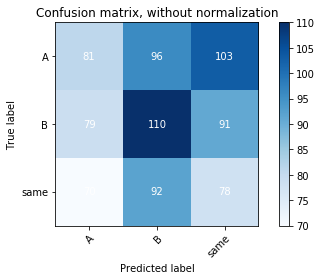

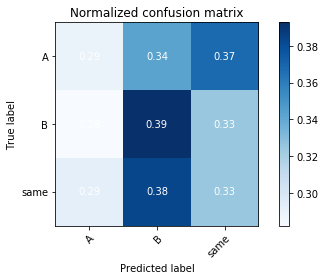

In [16]:
plot_confusion_matrix(Y, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y, predicted, classes=MASS_CLASS_COLS, normalize=True)

# Train model from scratch

In [30]:
model = ComplexRNNModel(16, 12, 6, 3)
model = model.cuda()

In [31]:
yoked_trials = read_dataset("yoked_trials_exp2.h5")

In [32]:
X = []
Y = []

for trial in yoked_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

X_scaled = (X - attr_means) / attr_std

In [33]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify=Y)

In [34]:
X_train = torch.from_numpy(X_train).cuda()
X_val = torch.from_numpy(X_val).cuda()
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor).cuda()
Y_val = torch.from_numpy(Y_val).type(torch.LongTensor).cuda()

train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=False)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

## Training loop

In [36]:
# Cross Entropy Loss 
error = nn.CrossEntropyLoss().cuda()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
epoch_losses = []
epoch_accuracies = []

In [44]:
num_epochs = 200

for epoch in  tqdm(range(num_epochs)):
    
    epoch_loss = 0
    
    for i, (x, y) in enumerate(train_loader):
        
        x = Variable(x)
        y = Variable(y)
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(x)
            
        # Calculate softmax and ross entropy loss
        loss = error(y_hat, y)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        
    epoch_losses.append(epoch_loss / len(train_loader))
    
    correct = 0
    total = 0

    for x_val, y_val in val_loader:
        x_val = Variable(x_val)
        y_hat = model(x_val)

        predicted = torch.max(y_hat.data, 1)[1]
        
        total += y_val.size(0)
        correct += (predicted == y_val).sum()

    accuracy = 100 * correct / float(total)
    
    epoch_accuracies.append(accuracy)
    
    print(epoch_losses[-1], epoch_accuracies[-1])


  0%|          | 1/200 [00:00<01:25,  2.34it/s]

0.7502486109733582 tensor(38, device='cuda:0')



  1%|          | 2/200 [00:00<01:21,  2.44it/s]

0.7354769706726074 tensor(40, device='cuda:0')



  2%|▏         | 3/200 [00:01<01:17,  2.54it/s]

0.7340292930603027 tensor(39, device='cuda:0')



  2%|▏         | 4/200 [00:01<01:17,  2.54it/s]

0.7396312952041626 tensor(38, device='cuda:0')



  2%|▎         | 5/200 [00:01<01:15,  2.60it/s]

0.7321663498878479 tensor(38, device='cuda:0')



  3%|▎         | 6/200 [00:02<01:16,  2.52it/s]

0.7319319248199463 tensor(38, device='cuda:0')



  4%|▎         | 7/200 [00:02<01:17,  2.49it/s]

0.7306180000305176 tensor(38, device='cuda:0')



  4%|▍         | 8/200 [00:03<01:16,  2.51it/s]

0.728204071521759 tensor(38, device='cuda:0')



  4%|▍         | 9/200 [00:03<01:14,  2.55it/s]

0.7253109216690063 tensor(38, device='cuda:0')



  5%|▌         | 10/200 [00:03<01:14,  2.55it/s]

0.7240424752235413 tensor(37, device='cuda:0')



  6%|▌         | 11/200 [00:04<01:13,  2.57it/s]

0.7250776886940002 tensor(36, device='cuda:0')



  6%|▌         | 12/200 [00:04<01:10,  2.67it/s]

0.7218579649925232 tensor(36, device='cuda:0')



  6%|▋         | 13/200 [00:04<01:09,  2.70it/s]

0.7221392393112183 tensor(36, device='cuda:0')



  7%|▋         | 14/200 [00:05<01:08,  2.70it/s]

0.7194257974624634 tensor(36, device='cuda:0')



  8%|▊         | 15/200 [00:05<01:08,  2.69it/s]

0.7196506261825562 tensor(36, device='cuda:0')



  8%|▊         | 16/200 [00:06<01:08,  2.67it/s]

0.7172091603279114 tensor(36, device='cuda:0')



  8%|▊         | 17/200 [00:06<01:08,  2.65it/s]

0.7149708271026611 tensor(36, device='cuda:0')



  9%|▉         | 18/200 [00:06<01:09,  2.61it/s]

0.7145864963531494 tensor(36, device='cuda:0')



 10%|▉         | 19/200 [00:07<01:09,  2.61it/s]

0.7128230929374695 tensor(36, device='cuda:0')



 10%|█         | 20/200 [00:07<01:09,  2.59it/s]

0.7135747671127319 tensor(36, device='cuda:0')



 10%|█         | 21/200 [00:08<01:09,  2.59it/s]

0.7143187522888184 tensor(36, device='cuda:0')



 11%|█         | 22/200 [00:08<01:08,  2.60it/s]

0.7104505300521851 tensor(36, device='cuda:0')



 12%|█▏        | 23/200 [00:08<01:07,  2.62it/s]

0.7095305919647217 tensor(36, device='cuda:0')



 12%|█▏        | 24/200 [00:09<01:06,  2.66it/s]

0.7087467908859253 tensor(36, device='cuda:0')



 12%|█▎        | 25/200 [00:09<01:03,  2.76it/s]

0.7086066603660583 tensor(36, device='cuda:0')



 13%|█▎        | 26/200 [00:09<01:02,  2.78it/s]

0.7084410190582275 tensor(36, device='cuda:0')



 14%|█▎        | 27/200 [00:10<01:04,  2.70it/s]

0.7070059776306152 tensor(36, device='cuda:0')



 14%|█▍        | 28/200 [00:10<01:03,  2.71it/s]

0.7065659761428833 tensor(36, device='cuda:0')



 14%|█▍        | 29/200 [00:10<01:03,  2.71it/s]

0.7056384682655334 tensor(36, device='cuda:0')



 15%|█▌        | 30/200 [00:11<01:03,  2.69it/s]

0.7051858305931091 tensor(37, device='cuda:0')



 16%|█▌        | 31/200 [00:11<01:04,  2.64it/s]

0.7044976353645325 tensor(36, device='cuda:0')



 16%|█▌        | 32/200 [00:12<01:03,  2.63it/s]

0.7037175297737122 tensor(36, device='cuda:0')



 16%|█▋        | 33/200 [00:12<01:03,  2.62it/s]

0.703356146812439 tensor(36, device='cuda:0')



 17%|█▋        | 34/200 [00:12<01:01,  2.72it/s]

0.7025617957115173 tensor(36, device='cuda:0')



 18%|█▊        | 35/200 [00:13<00:58,  2.81it/s]

0.7020896077156067 tensor(36, device='cuda:0')



 18%|█▊        | 36/200 [00:13<00:59,  2.78it/s]

0.7014035582542419 tensor(37, device='cuda:0')



 18%|█▊        | 37/200 [00:13<01:00,  2.68it/s]

0.7005468606948853 tensor(38, device='cuda:0')



 19%|█▉        | 38/200 [00:14<01:00,  2.66it/s]

0.6999805569648743 tensor(38, device='cuda:0')



 20%|█▉        | 39/200 [00:14<00:59,  2.70it/s]

0.6991040110588074 tensor(38, device='cuda:0')



 20%|██        | 40/200 [00:15<00:58,  2.72it/s]

0.697796642780304 tensor(38, device='cuda:0')



 20%|██        | 41/200 [00:15<01:00,  2.63it/s]

0.6971191763877869 tensor(38, device='cuda:0')



 21%|██        | 42/200 [00:15<00:59,  2.66it/s]

0.6964750289916992 tensor(38, device='cuda:0')



 22%|██▏       | 43/200 [00:16<00:59,  2.64it/s]

0.695754885673523 tensor(38, device='cuda:0')



 22%|██▏       | 44/200 [00:16<00:59,  2.63it/s]

0.6949889659881592 tensor(38, device='cuda:0')



 22%|██▎       | 45/200 [00:16<00:58,  2.63it/s]

0.6945192813873291 tensor(38, device='cuda:0')



 23%|██▎       | 46/200 [00:17<00:56,  2.70it/s]

0.694055438041687 tensor(38, device='cuda:0')



 24%|██▎       | 47/200 [00:17<00:56,  2.71it/s]

0.6940110921859741 tensor(38, device='cuda:0')



 24%|██▍       | 48/200 [00:18<00:55,  2.76it/s]

0.6929613351821899 tensor(38, device='cuda:0')



 24%|██▍       | 49/200 [00:18<00:53,  2.82it/s]

0.692948043346405 tensor(38, device='cuda:0')



 25%|██▌       | 50/200 [00:18<00:52,  2.86it/s]

0.692711591720581 tensor(38, device='cuda:0')



 26%|██▌       | 51/200 [00:19<00:51,  2.90it/s]

0.6919634938240051 tensor(39, device='cuda:0')



 26%|██▌       | 52/200 [00:19<00:52,  2.80it/s]

0.6911329627037048 tensor(39, device='cuda:0')



 26%|██▋       | 53/200 [00:19<00:51,  2.88it/s]

0.691161036491394 tensor(38, device='cuda:0')



 27%|██▋       | 54/200 [00:20<00:50,  2.92it/s]

0.6916604042053223 tensor(38, device='cuda:0')



 28%|██▊       | 55/200 [00:20<00:51,  2.84it/s]

0.6924474239349365 tensor(38, device='cuda:0')



 28%|██▊       | 56/200 [00:20<00:52,  2.75it/s]

0.6939133405685425 tensor(38, device='cuda:0')



 28%|██▊       | 57/200 [00:21<00:52,  2.72it/s]

0.6929026246070862 tensor(36, device='cuda:0')



 29%|██▉       | 58/200 [00:21<00:52,  2.69it/s]

0.6924095153808594 tensor(37, device='cuda:0')



 30%|██▉       | 59/200 [00:22<00:53,  2.64it/s]

0.6921206712722778 tensor(37, device='cuda:0')



 30%|███       | 60/200 [00:22<00:52,  2.65it/s]

0.6924010515213013 tensor(37, device='cuda:0')



 30%|███       | 61/200 [00:22<00:52,  2.66it/s]

0.6903198957443237 tensor(38, device='cuda:0')



 31%|███       | 62/200 [00:23<00:53,  2.59it/s]

0.6902265548706055 tensor(38, device='cuda:0')



 32%|███▏      | 63/200 [00:23<00:53,  2.58it/s]

0.6907150149345398 tensor(38, device='cuda:0')



 32%|███▏      | 64/200 [00:23<00:52,  2.61it/s]

0.689487636089325 tensor(38, device='cuda:0')



 32%|███▎      | 65/200 [00:24<00:51,  2.61it/s]

0.6881276369094849 tensor(38, device='cuda:0')



 33%|███▎      | 66/200 [00:24<00:51,  2.62it/s]

0.6876838803291321 tensor(38, device='cuda:0')



 34%|███▎      | 67/200 [00:25<00:50,  2.61it/s]

0.6874434947967529 tensor(37, device='cuda:0')



 34%|███▍      | 68/200 [00:25<00:50,  2.63it/s]

0.6873422265052795 tensor(38, device='cuda:0')



 34%|███▍      | 69/200 [00:25<00:50,  2.60it/s]

0.6865679025650024 tensor(38, device='cuda:0')



 35%|███▌      | 70/200 [00:26<00:48,  2.67it/s]

0.6860530972480774 tensor(37, device='cuda:0')



 36%|███▌      | 71/200 [00:26<00:47,  2.69it/s]

0.6860874891281128 tensor(37, device='cuda:0')



 36%|███▌      | 72/200 [00:26<00:48,  2.66it/s]

0.6855700016021729 tensor(37, device='cuda:0')



 36%|███▋      | 73/200 [00:27<00:46,  2.73it/s]

0.6837326884269714 tensor(37, device='cuda:0')



 37%|███▋      | 74/200 [00:27<00:45,  2.78it/s]

0.6833890080451965 tensor(38, device='cuda:0')



 38%|███▊      | 75/200 [00:28<00:46,  2.70it/s]

0.6825425624847412 tensor(38, device='cuda:0')



 38%|███▊      | 76/200 [00:28<00:45,  2.71it/s]

0.6823049783706665 tensor(37, device='cuda:0')



 38%|███▊      | 77/200 [00:28<00:45,  2.70it/s]

0.6811949014663696 tensor(37, device='cuda:0')



 39%|███▉      | 78/200 [00:29<00:45,  2.68it/s]

0.6805547475814819 tensor(37, device='cuda:0')



 40%|███▉      | 79/200 [00:29<00:44,  2.70it/s]

0.6797754168510437 tensor(37, device='cuda:0')



 40%|████      | 80/200 [00:29<00:44,  2.69it/s]

0.6797506213188171 tensor(37, device='cuda:0')



 40%|████      | 81/200 [00:30<00:43,  2.73it/s]

0.6786543130874634 tensor(37, device='cuda:0')



 41%|████      | 82/200 [00:30<00:43,  2.74it/s]

0.6776617169380188 tensor(37, device='cuda:0')



 42%|████▏     | 83/200 [00:31<00:43,  2.70it/s]

0.6768923997879028 tensor(38, device='cuda:0')



 42%|████▏     | 84/200 [00:31<00:42,  2.72it/s]

0.6757955551147461 tensor(38, device='cuda:0')



 42%|████▎     | 85/200 [00:31<00:43,  2.62it/s]

0.6738549470901489 tensor(38, device='cuda:0')



 43%|████▎     | 86/200 [00:32<00:43,  2.62it/s]

0.6771001815795898 tensor(38, device='cuda:0')



 44%|████▎     | 87/200 [00:32<00:43,  2.62it/s]

0.6736032366752625 tensor(38, device='cuda:0')



 44%|████▍     | 88/200 [00:32<00:42,  2.63it/s]

0.6731728315353394 tensor(38, device='cuda:0')



 44%|████▍     | 89/200 [00:33<00:41,  2.68it/s]

0.6725635528564453 tensor(38, device='cuda:0')



 45%|████▌     | 90/200 [00:33<00:41,  2.66it/s]

0.6717901825904846 tensor(38, device='cuda:0')



 46%|████▌     | 91/200 [00:34<00:39,  2.73it/s]

0.6710425615310669 tensor(39, device='cuda:0')



 46%|████▌     | 92/200 [00:34<00:38,  2.80it/s]

0.6702374815940857 tensor(39, device='cuda:0')



 46%|████▋     | 93/200 [00:34<00:37,  2.82it/s]

0.6696788668632507 tensor(38, device='cuda:0')



 47%|████▋     | 94/200 [00:35<00:37,  2.86it/s]

0.6708093285560608 tensor(38, device='cuda:0')



 48%|████▊     | 95/200 [00:35<00:37,  2.83it/s]

0.668598473072052 tensor(39, device='cuda:0')



 48%|████▊     | 96/200 [00:35<00:36,  2.86it/s]

0.671150267124176 tensor(38, device='cuda:0')



 48%|████▊     | 97/200 [00:36<00:35,  2.90it/s]

0.6715356707572937 tensor(39, device='cuda:0')



 49%|████▉     | 98/200 [00:36<00:35,  2.87it/s]

0.6680404543876648 tensor(39, device='cuda:0')



 50%|████▉     | 99/200 [00:36<00:34,  2.89it/s]

0.6688127517700195 tensor(37, device='cuda:0')



 50%|█████     | 100/200 [00:37<00:34,  2.91it/s]

0.6669396162033081 tensor(38, device='cuda:0')



 50%|█████     | 101/200 [00:37<00:34,  2.89it/s]

0.6663283705711365 tensor(38, device='cuda:0')



 51%|█████     | 102/200 [00:37<00:33,  2.89it/s]

0.6659663915634155 tensor(38, device='cuda:0')



 52%|█████▏    | 103/200 [00:38<00:33,  2.86it/s]

0.6639326810836792 tensor(38, device='cuda:0')



 52%|█████▏    | 104/200 [00:38<00:33,  2.87it/s]

0.6633210778236389 tensor(38, device='cuda:0')



 52%|█████▎    | 105/200 [00:38<00:33,  2.88it/s]

0.6631065011024475 tensor(38, device='cuda:0')



 53%|█████▎    | 106/200 [00:39<00:32,  2.90it/s]

0.6652406454086304 tensor(38, device='cuda:0')



 54%|█████▎    | 107/200 [00:39<00:32,  2.87it/s]

0.6630515456199646 tensor(38, device='cuda:0')



 54%|█████▍    | 108/200 [00:39<00:32,  2.82it/s]

0.6614384055137634 tensor(38, device='cuda:0')



 55%|█████▍    | 109/200 [00:40<00:31,  2.87it/s]

0.6631224751472473 tensor(38, device='cuda:0')



 55%|█████▌    | 110/200 [00:40<00:31,  2.84it/s]

0.6589978933334351 tensor(38, device='cuda:0')



 56%|█████▌    | 111/200 [00:40<00:31,  2.86it/s]

0.6616986393928528 tensor(38, device='cuda:0')



 56%|█████▌    | 112/200 [00:41<00:31,  2.81it/s]

0.6581974625587463 tensor(38, device='cuda:0')



 56%|█████▋    | 113/200 [00:41<00:30,  2.85it/s]

0.6589479446411133 tensor(38, device='cuda:0')



 57%|█████▋    | 114/200 [00:42<00:30,  2.84it/s]

0.656413197517395 tensor(37, device='cuda:0')



 57%|█████▊    | 115/200 [00:42<00:29,  2.84it/s]

0.6584219336509705 tensor(38, device='cuda:0')



 58%|█████▊    | 116/200 [00:42<00:29,  2.85it/s]

0.65689617395401 tensor(38, device='cuda:0')



 58%|█████▊    | 117/200 [00:43<00:28,  2.86it/s]

0.6570178270339966 tensor(38, device='cuda:0')



 59%|█████▉    | 118/200 [00:43<00:28,  2.89it/s]

0.6553961634635925 tensor(38, device='cuda:0')



 60%|█████▉    | 119/200 [00:43<00:27,  2.91it/s]

0.6545503735542297 tensor(38, device='cuda:0')



 60%|██████    | 120/200 [00:44<00:27,  2.91it/s]

0.6546293497085571 tensor(38, device='cuda:0')



 60%|██████    | 121/200 [00:44<00:27,  2.88it/s]

0.6553901433944702 tensor(38, device='cuda:0')



 61%|██████    | 122/200 [00:44<00:26,  2.90it/s]

0.6552615761756897 tensor(38, device='cuda:0')



 62%|██████▏   | 123/200 [00:45<00:26,  2.87it/s]

0.6527564525604248 tensor(38, device='cuda:0')



 62%|██████▏   | 124/200 [00:45<00:27,  2.77it/s]

0.6547209620475769 tensor(38, device='cuda:0')



 62%|██████▎   | 125/200 [00:45<00:26,  2.81it/s]

0.6525949835777283 tensor(38, device='cuda:0')



 63%|██████▎   | 126/200 [00:46<00:27,  2.70it/s]

0.6513563990592957 tensor(38, device='cuda:0')



 64%|██████▎   | 127/200 [00:46<00:27,  2.69it/s]

0.6505417823791504 tensor(38, device='cuda:0')



 64%|██████▍   | 128/200 [00:47<00:27,  2.59it/s]

0.6502735018730164 tensor(38, device='cuda:0')



 64%|██████▍   | 129/200 [00:47<00:27,  2.58it/s]

0.6495979428291321 tensor(38, device='cuda:0')



 65%|██████▌   | 130/200 [00:47<00:27,  2.58it/s]

0.6512101888656616 tensor(38, device='cuda:0')



 66%|██████▌   | 131/200 [00:48<00:26,  2.61it/s]

0.6800323724746704 tensor(38, device='cuda:0')



 66%|██████▌   | 132/200 [00:48<00:26,  2.59it/s]

0.6972283720970154 tensor(38, device='cuda:0')



 66%|██████▋   | 133/200 [00:48<00:25,  2.62it/s]

0.7033535242080688 tensor(37, device='cuda:0')



 67%|██████▋   | 134/200 [00:49<00:24,  2.67it/s]

0.6987922787666321 tensor(36, device='cuda:0')



 68%|██████▊   | 135/200 [00:49<00:23,  2.75it/s]

0.6995073556900024 tensor(38, device='cuda:0')



 68%|██████▊   | 136/200 [00:50<00:23,  2.72it/s]

0.6942803859710693 tensor(38, device='cuda:0')



 68%|██████▊   | 137/200 [00:50<00:23,  2.66it/s]

0.7028776407241821 tensor(38, device='cuda:0')



 69%|██████▉   | 138/200 [00:50<00:23,  2.69it/s]

0.7141487002372742 tensor(38, device='cuda:0')



 70%|██████▉   | 139/200 [00:51<00:23,  2.62it/s]

0.7182510495185852 tensor(39, device='cuda:0')



 70%|███████   | 140/200 [00:51<00:22,  2.63it/s]

0.7195234894752502 tensor(38, device='cuda:0')



 70%|███████   | 141/200 [00:51<00:22,  2.65it/s]

0.7068517208099365 tensor(38, device='cuda:0')



 71%|███████   | 142/200 [00:52<00:21,  2.65it/s]

0.7029566764831543 tensor(38, device='cuda:0')



 72%|███████▏  | 143/200 [00:52<00:22,  2.57it/s]

0.6980583667755127 tensor(39, device='cuda:0')



 72%|███████▏  | 144/200 [00:53<00:22,  2.55it/s]

0.6982178092002869 tensor(40, device='cuda:0')



 72%|███████▎  | 145/200 [00:53<00:22,  2.43it/s]

0.6956782937049866 tensor(40, device='cuda:0')



 73%|███████▎  | 146/200 [00:54<00:21,  2.46it/s]

0.7006226778030396 tensor(39, device='cuda:0')



 74%|███████▎  | 147/200 [00:54<00:21,  2.50it/s]

0.6958833336830139 tensor(39, device='cuda:0')



 74%|███████▍  | 148/200 [00:54<00:20,  2.53it/s]

0.6906577944755554 tensor(40, device='cuda:0')



 74%|███████▍  | 149/200 [00:55<00:20,  2.50it/s]

0.688731849193573 tensor(42, device='cuda:0')



 75%|███████▌  | 150/200 [00:55<00:20,  2.45it/s]

0.687282383441925 tensor(41, device='cuda:0')



 76%|███████▌  | 151/200 [00:56<00:19,  2.49it/s]

0.6853033900260925 tensor(41, device='cuda:0')



 76%|███████▌  | 152/200 [00:56<00:18,  2.58it/s]

0.6842960119247437 tensor(41, device='cuda:0')



 76%|███████▋  | 153/200 [00:56<00:17,  2.64it/s]

0.6827921867370605 tensor(42, device='cuda:0')



 77%|███████▋  | 154/200 [00:57<00:17,  2.69it/s]

0.6807606220245361 tensor(43, device='cuda:0')



 78%|███████▊  | 155/200 [00:57<00:16,  2.70it/s]

0.6760615110397339 tensor(42, device='cuda:0')



 78%|███████▊  | 156/200 [00:57<00:16,  2.69it/s]

0.674232006072998 tensor(41, device='cuda:0')



 78%|███████▊  | 157/200 [00:58<00:16,  2.65it/s]

0.6707860231399536 tensor(40, device='cuda:0')



 79%|███████▉  | 158/200 [00:58<00:16,  2.62it/s]

0.6691821217536926 tensor(39, device='cuda:0')



 80%|███████▉  | 159/200 [00:58<00:15,  2.69it/s]

0.6674996614456177 tensor(38, device='cuda:0')



 80%|████████  | 160/200 [00:59<00:14,  2.73it/s]

0.6676350235939026 tensor(38, device='cuda:0')



 80%|████████  | 161/200 [00:59<00:14,  2.78it/s]

0.6668232083320618 tensor(38, device='cuda:0')



 81%|████████  | 162/200 [00:59<00:13,  2.82it/s]

0.6649004220962524 tensor(38, device='cuda:0')



 82%|████████▏ | 163/200 [01:00<00:13,  2.73it/s]

0.6630082130432129 tensor(38, device='cuda:0')



 82%|████████▏ | 164/200 [01:00<00:13,  2.76it/s]

0.6620673537254333 tensor(37, device='cuda:0')



 82%|████████▎ | 165/200 [01:01<00:12,  2.80it/s]

0.661521315574646 tensor(38, device='cuda:0')



 83%|████████▎ | 166/200 [01:01<00:12,  2.71it/s]

0.6614908576011658 tensor(38, device='cuda:0')



 84%|████████▎ | 167/200 [01:01<00:12,  2.64it/s]

0.6608628630638123 tensor(38, device='cuda:0')



 84%|████████▍ | 168/200 [01:02<00:12,  2.65it/s]

0.6632397174835205 tensor(38, device='cuda:0')



 84%|████████▍ | 169/200 [01:02<00:12,  2.58it/s]

0.6600688099861145 tensor(38, device='cuda:0')



 85%|████████▌ | 170/200 [01:03<00:11,  2.65it/s]

0.6558972001075745 tensor(39, device='cuda:0')



 86%|████████▌ | 171/200 [01:03<00:11,  2.62it/s]

0.6762005090713501 tensor(40, device='cuda:0')



 86%|████████▌ | 172/200 [01:03<00:10,  2.66it/s]

0.6974380612373352 tensor(40, device='cuda:0')



 86%|████████▋ | 173/200 [01:04<00:10,  2.64it/s]

0.7086003422737122 tensor(40, device='cuda:0')



 87%|████████▋ | 174/200 [01:04<00:09,  2.66it/s]

0.7226307988166809 tensor(38, device='cuda:0')



 88%|████████▊ | 175/200 [01:04<00:09,  2.59it/s]

0.7203360199928284 tensor(38, device='cuda:0')



 88%|████████▊ | 176/200 [01:05<00:09,  2.64it/s]

0.7108949422836304 tensor(38, device='cuda:0')



 88%|████████▊ | 177/200 [01:05<00:08,  2.57it/s]

0.7054471969604492 tensor(40, device='cuda:0')



 89%|████████▉ | 178/200 [01:06<00:08,  2.64it/s]

0.7045694589614868 tensor(42, device='cuda:0')



 90%|████████▉ | 179/200 [01:06<00:07,  2.69it/s]

0.692282497882843 tensor(41, device='cuda:0')



 90%|█████████ | 180/200 [01:06<00:07,  2.75it/s]

0.6872552633285522 tensor(43, device='cuda:0')



 90%|█████████ | 181/200 [01:07<00:06,  2.75it/s]

0.7109407186508179 tensor(41, device='cuda:0')



 91%|█████████ | 182/200 [01:07<00:06,  2.78it/s]

0.763337254524231 tensor(38, device='cuda:0')



 92%|█████████▏| 183/200 [01:07<00:06,  2.80it/s]

0.8127735257148743 tensor(39, device='cuda:0')



 92%|█████████▏| 184/200 [01:08<00:05,  2.80it/s]

0.8534139394760132 tensor(37, device='cuda:0')



 92%|█████████▎| 185/200 [01:08<00:05,  2.83it/s]

0.8913960456848145 tensor(36, device='cuda:0')



 93%|█████████▎| 186/200 [01:08<00:04,  2.84it/s]

0.922924816608429 tensor(38, device='cuda:0')



 94%|█████████▎| 187/200 [01:09<00:04,  2.84it/s]

0.946701169013977 tensor(38, device='cuda:0')



 94%|█████████▍| 188/200 [01:09<00:04,  2.84it/s]

0.9539604187011719 tensor(39, device='cuda:0')



 94%|█████████▍| 189/200 [01:09<00:04,  2.74it/s]

0.9610915184020996 tensor(40, device='cuda:0')



 95%|█████████▌| 190/200 [01:10<00:03,  2.74it/s]

0.9550121426582336 tensor(38, device='cuda:0')



 96%|█████████▌| 191/200 [01:10<00:03,  2.63it/s]

0.9278416633605957 tensor(38, device='cuda:0')



 96%|█████████▌| 192/200 [01:11<00:02,  2.68it/s]

0.9015653729438782 tensor(37, device='cuda:0')



 96%|█████████▋| 193/200 [01:11<00:02,  2.62it/s]

0.8819805383682251 tensor(38, device='cuda:0')



 97%|█████████▋| 194/200 [01:11<00:02,  2.62it/s]

0.8693402409553528 tensor(38, device='cuda:0')



 98%|█████████▊| 195/200 [01:12<00:01,  2.59it/s]

0.8516119718551636 tensor(40, device='cuda:0')



 98%|█████████▊| 196/200 [01:12<00:01,  2.66it/s]

0.83839350938797 tensor(39, device='cuda:0')



 98%|█████████▊| 197/200 [01:13<00:01,  2.55it/s]

0.8243433833122253 tensor(41, device='cuda:0')



 99%|█████████▉| 198/200 [01:13<00:00,  2.64it/s]

0.8184967041015625 tensor(41, device='cuda:0')



100%|█████████▉| 199/200 [01:13<00:00,  2.62it/s]

0.8140596151351929 tensor(42, device='cuda:0')



100%|██████████| 200/200 [01:14<00:00,  2.67it/s]

0.8054812550544739 tensor(43, device='cuda:0')


In [45]:
import matplotlib.pyplot as plt

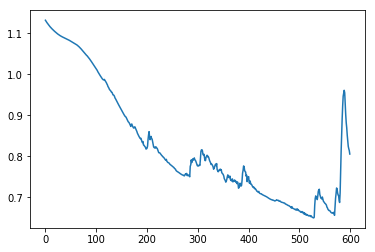

In [46]:
plt.plot(epoch_losses)

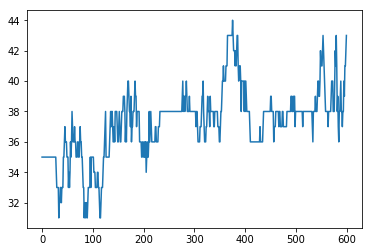

In [47]:
plt.plot(epoch_accuracies)

In [43]:
np.unique(Y, return_counts=True)

(array([0, 1, 2]), array([280, 280, 240]))